# Tests for epoch length and number of neurons

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import time
from training_functions import *
import logging

In [3]:
logging.basicConfig(level=logging.INFO)

## Data exploration and Preprocessing

#### Get the data from ES and create a pandas dataframe

We take datapoints in the range of the 9th and 13th of June with a sample rate of 20. 

In [4]:
q_one = es_to_df(start_date="2020-06-09",end_date="2020-06-13", s_rate=20, tier="censhare", host='localhost', port=9200)
q_two = es_to_df(start_date="2020-06-09",end_date="2020-06-13", s_rate=20, tier="pic", host='localhost', port=9200)

INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.091s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.080s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.079s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.119s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.199s]
INFO:root:ES to Df: 0.94 time elapsed
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.113s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.658s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.695s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.133s]
INFO:elasticsearch:POST http://localhost:9200/queues/_search [status:200 request:0.186s]
INFO:root:ES to Df: 2.41 time elapsed


#### Overview of the changing queue size over time

In [5]:
q_one_size = q_one['size']
q_two_size = q_two['size']

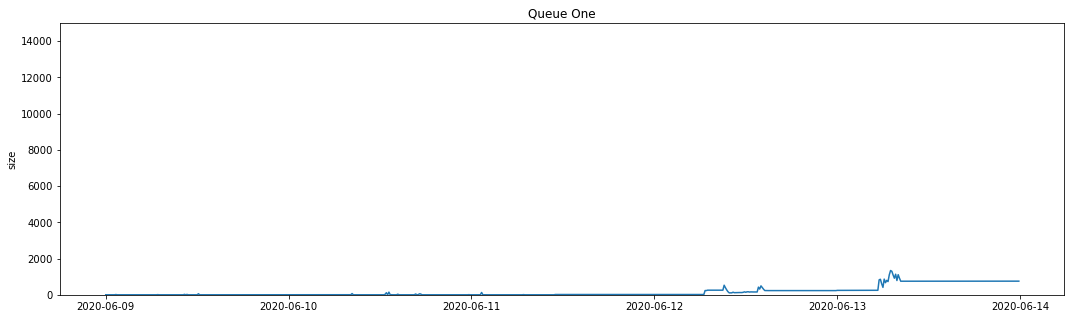

In [6]:
plt.figure(figsize=[18,5])
plt.title('Queue One')
plt.ylabel('size')
plt.ylim(0,15000)
plt.plot(q_one_size)
#plt.savefig('q1size.png')

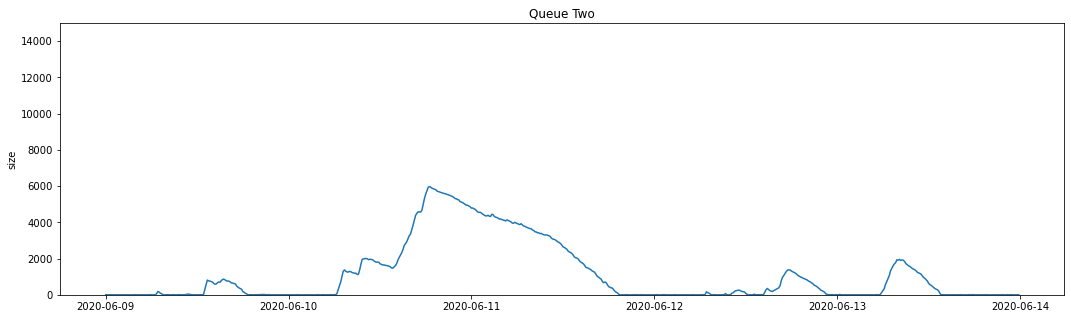

In [7]:
plt.figure(figsize=[18,5])
plt.title('Queue Two')
plt.ylabel('size')
plt.ylim(0,15000)
plt.plot(q_two_size)
#plt.savefig('q2size.png')

#### Create the feature enriched dataset for each item

In [8]:
X, y, maxlen = create_dataset_train(q_one, q_two)

INFO:root:3215 items in the first and second queue
INFO:root:11177 items in the second queue only
INFO:root:14392 items in the whole dataset
INFO:root:Create dataset: 20.00 time elapsed


#### Overview of the samples

Create maxlenlist containing the maximum number of steps each sample is in the queue

In [9]:
maxlenlist, mean, median = get_max_len_list_mean_median(y)

Show the mean and median of the sample lengths

$$\textrm{mean}(x) = \dfrac{\sum\limits_{i=1}^N x_i}{N} = \frac{x_1 + x_2 + \cdot \cdot \cdot + x_N}{N} $$

$$\textrm{median}(x)
=\begin{cases}
  x_\frac{n+1}{2}                                    & n\text{ odd}\\
  \frac {1}{2}\left(x_{\frac{n}{2}} + x_{\frac{n}{2} + 1}\right) & n \text{ even}
\end{cases}$$

In [10]:
mean, median

(77, 35)

#### Histogram

Show histogram of the distribution of each sample length

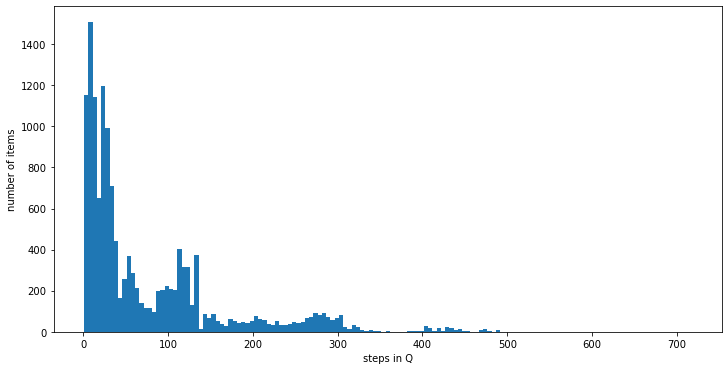

In [11]:
plt.figure(figsize=[5.98543*2,5.98543])
plt.hist(maxlenlist,bins=int(len(maxlenlist)/100))
plt.ylabel('number of items')
plt.xlabel('steps in Q')
plt.savefig('histnov.png')
plt.show()

Show the most common occurence of lengths

In [12]:
from collections import Counter

In [13]:
#Counter(maxlenlist).most_common()

Head of an individual sample

In [14]:
X[0].head()

,1000329377,Q_size_one,Q_size_two,n_added_two,n_removed_two,Q_start
0,1,856,27,27,1,0
1,2,609,135,135,27,0
2,3,410,233,194,96,0
3,4,865,332,147,48,0
4,5,669,575,285,42,0


In [15]:
y[0].head()

,1000329377
0,10
1,9
2,8
3,7
4,6


#### Scaling

In [16]:
X_scaled, y_scaled = scale(X, y, start_date="2020-06-09",end_date="2020-06-13", 
                           epochs='50', steps='720', s_rate='20', model_name='test')

INFO:root:Scale: 68.44 time elapsed


#### Padding

In [17]:
X_train, X_test, y_train, y_test = pad_split(X_scaled, y_scaled, maxlen, test_size=0.3)

INFO:root:Pad Split: 0.26 time elapsed


In [18]:
X_train[0]

array([[-1.0377314 , -0.31592798,  0.17409715,  1.9188763 ,  0.1271709 ,
         0.41861403],
       [-1.0262443 , -0.31592798,  0.2596502 ,  2.2111454 ,  0.89768004,
         0.41861403],
       [-1.0147572 , -0.31592798,  0.30443975,  1.0186877 ,  0.1271709 ,
         0.41861403],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

In [19]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = downsample(X_train, X_test, y_train, y_test, rate=0.8)

INFO:root:Downsample: 0.07 time elapsed


Shape of the trainings samples (number of samples, timesteps, features)

In [20]:
X_train_sampled.shape

(8086, 720, 6)

In [22]:
X_test_sampled.shape

(3486, 720, 6)

In [23]:
len(X_scaled)

14392

## LSTM

## Epoch Tests

#### 10 Epochs

In [24]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_10epochs_20neurons.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=10, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_10epochs_20neurons.h5')

Epoch 1/10
203/203 [==============================] - 120s 590ms/step - loss: 0.0633 - mae: 0.5754 - val_loss: 0.0505 - val_mae: 0.4816
Epoch 2/10
203/203 [==============================] - 104s 510ms/step - loss: 0.0530 - mae: 0.4816 - val_loss: 0.0460 - val_mae: 0.4387
Epoch 3/10
203/203 [==============================] - 104s 511ms/step - loss: 0.0509 - mae: 0.4629 - val_loss: 0.0446 - val_mae: 0.4252
Epoch 4/10
203/203 [==============================] - 104s 513ms/step - loss: 0.0499 - mae: 0.4540 - val_loss: 0.0441 - val_mae: 0.4200
Epoch 5/10
203/203 [==============================] - 104s 514ms/step - loss: 0.0502 - mae: 0.4566 - val_loss: 0.0440 - val_mae: 0.4195
Epoch 6/10
203/203 [==============================] - 104s 511ms/step - loss: 0.0485 - mae: 0.4414 - val_loss: 0.0428 - val_mae: 0.4080
Epoch 7/10
203/203 [==============================] - 104s 512ms/step - loss: 0.0477 - mae: 0.4336 - val_loss: 0.0444 - val_mae: 0.4231
Epoch 8/10
203/203 [============================

MAE        :  35.37
MAE Mean   :  82.27
MAE Median :  87.23


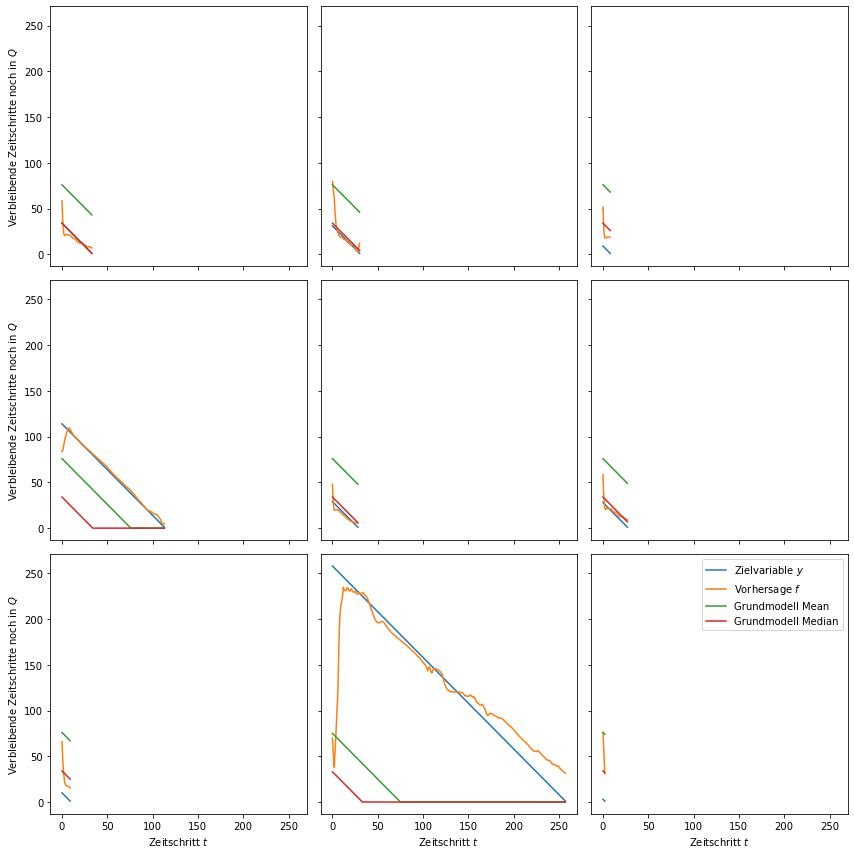

In [25]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_10epochs_20neurons.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

#### 25 Epochs

In [26]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_25epochs_20neurons.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=25, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_25epochs_20neurons.h5')

Epoch 1/25
203/203 [==============================] - 121s 596ms/step - loss: 0.0630 - mae: 0.5726 - val_loss: 0.0495 - val_mae: 0.4721
Epoch 2/25
203/203 [==============================] - 104s 513ms/step - loss: 0.0529 - mae: 0.4810 - val_loss: 0.0469 - val_mae: 0.4468
Epoch 3/25
203/203 [==============================] - 105s 516ms/step - loss: 0.0505 - mae: 0.4590 - val_loss: 0.0449 - val_mae: 0.4277
Epoch 4/25
203/203 [==============================] - 104s 512ms/step - loss: 0.0488 - mae: 0.4435 - val_loss: 0.0433 - val_mae: 0.4126
Epoch 5/25
203/203 [==============================] - 104s 514ms/step - loss: 0.0479 - mae: 0.4356 - val_loss: 0.0428 - val_mae: 0.4074
Epoch 6/25
203/203 [==============================] - 104s 515ms/step - loss: 0.0476 - mae: 0.4332 - val_loss: 0.0427 - val_mae: 0.4065
Epoch 7/25
203/203 [==============================] - 104s 513ms/step - loss: 0.0470 - mae: 0.4271 - val_loss: 0.0425 - val_mae: 0.4049
Epoch 8/25
203/203 [============================

MAE        :  34.05
MAE Mean   :  82.27
MAE Median :  87.23


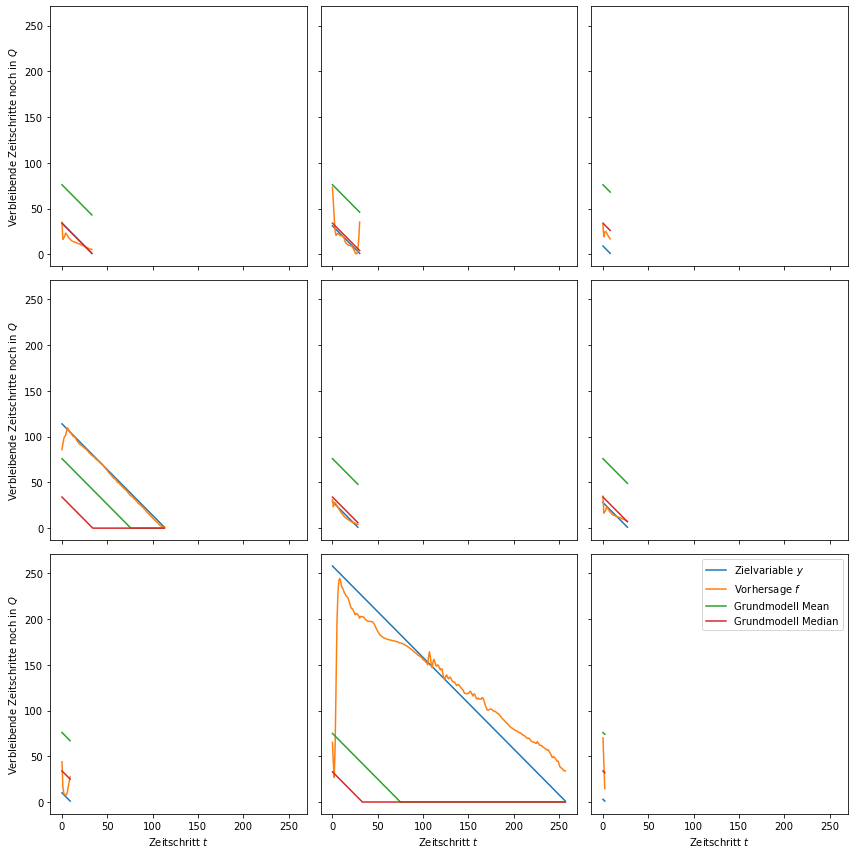

In [27]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_25epochs_20neurons.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

#### 50 Epochs

In [28]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_50epochs_20neurons.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=50, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_50epochs_20neurons.h5')

Epoch 1/50
203/203 [==============================] - 118s 583ms/step - loss: 0.0632 - mae: 0.5746 - val_loss: 0.0519 - val_mae: 0.4943
Epoch 2/50
203/203 [==============================] - 102s 502ms/step - loss: 0.0541 - mae: 0.4921 - val_loss: 0.0475 - val_mae: 0.4523
Epoch 3/50
203/203 [==============================] - 102s 502ms/step - loss: 0.0518 - mae: 0.4715 - val_loss: 0.0470 - val_mae: 0.4480
Epoch 4/50
203/203 [==============================] - 102s 503ms/step - loss: 0.0503 - mae: 0.4573 - val_loss: 0.0455 - val_mae: 0.4335
Epoch 5/50
203/203 [==============================] - 102s 503ms/step - loss: 0.0492 - mae: 0.4476 - val_loss: 0.0433 - val_mae: 0.4122
Epoch 6/50
203/203 [==============================] - 102s 502ms/step - loss: 0.0489 - mae: 0.4444 - val_loss: 0.0434 - val_mae: 0.4140
Epoch 7/50
203/203 [==============================] - 102s 502ms/step - loss: 0.0477 - mae: 0.4342 - val_loss: 0.0425 - val_mae: 0.4048
Epoch 8/50
203/203 [============================

MAE        :  32.93
MAE Mean   :  82.27
MAE Median :  87.23


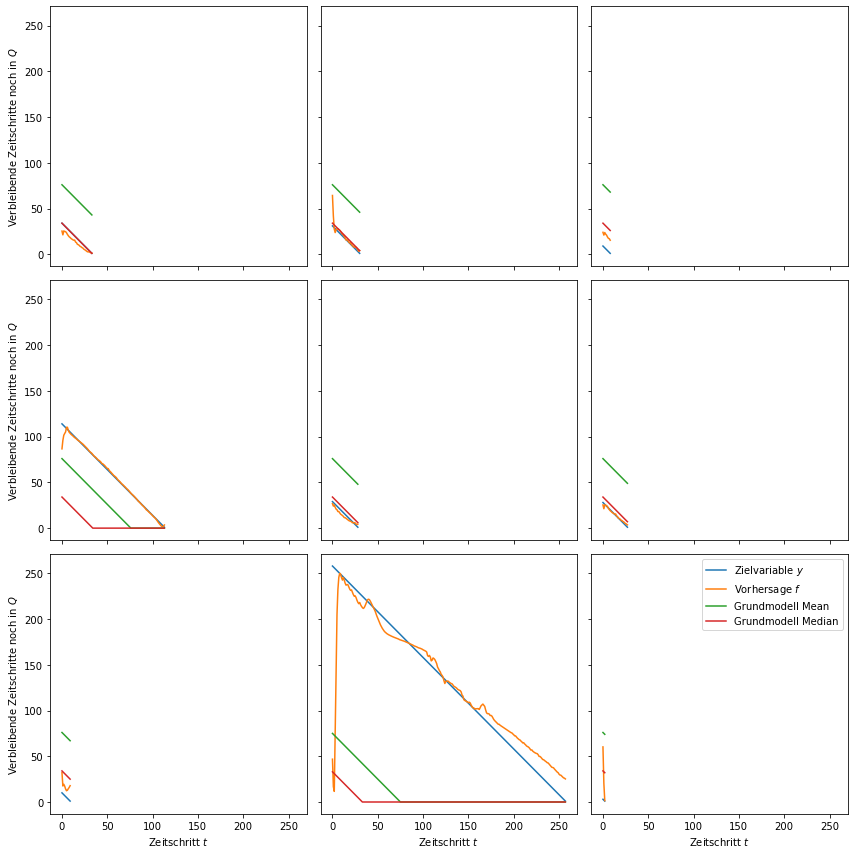

In [29]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_50epochs_20neurons.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

### Neurons Test

#### 10 Neurons

In [30]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(10, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_20epochs_10neurons.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=20, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_20epochs_10neurons.h5')

Epoch 1/20
203/203 [==============================] - 111s 549ms/step - loss: 0.0672 - mae: 0.6112 - val_loss: 0.0538 - val_mae: 0.5126
Epoch 2/20
203/203 [==============================] - 104s 514ms/step - loss: 0.0573 - mae: 0.5211 - val_loss: 0.0508 - val_mae: 0.4837
Epoch 3/20
203/203 [==============================] - 104s 514ms/step - loss: 0.0557 - mae: 0.5063 - val_loss: 0.0491 - val_mae: 0.4682
Epoch 4/20
203/203 [==============================] - 104s 514ms/step - loss: 0.0534 - mae: 0.4859 - val_loss: 0.0475 - val_mae: 0.4525
Epoch 5/20
203/203 [==============================] - 104s 513ms/step - loss: 0.0525 - mae: 0.4772 - val_loss: 0.0460 - val_mae: 0.4384
Epoch 6/20
203/203 [==============================] - 104s 514ms/step - loss: 0.0509 - mae: 0.4628 - val_loss: 0.0459 - val_mae: 0.4369
Epoch 7/20
203/203 [==============================] - 104s 515ms/step - loss: 0.0506 - mae: 0.4603 - val_loss: 0.0454 - val_mae: 0.4326
Epoch 8/20
203/203 [============================

MAE        :  35.93
MAE Mean   :  82.27
MAE Median :  87.23


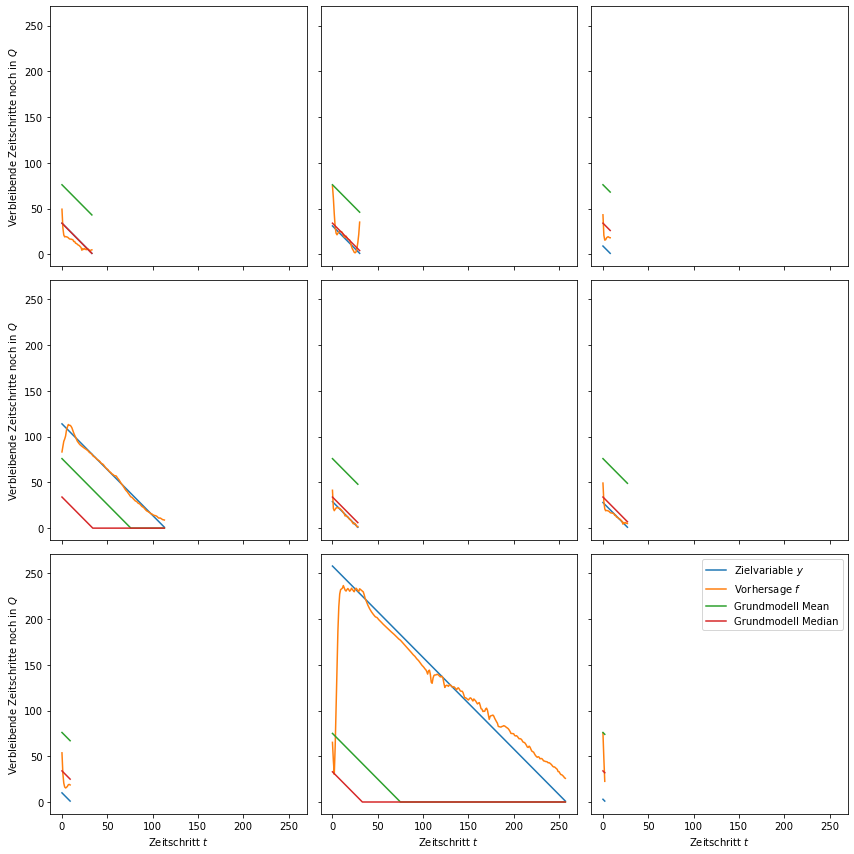

In [31]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_20epochs_10neurons.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

#### 25 Neurons

In [32]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(25, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_20epochs_25neurons.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=20, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_20epochs_25neurons.h5')

Epoch 1/20
203/203 [==============================] - 125s 616ms/step - loss: 0.0619 - mae: 0.5628 - val_loss: 0.0533 - val_mae: 0.5082
Epoch 2/20
203/203 [==============================] - 104s 514ms/step - loss: 0.0530 - mae: 0.4818 - val_loss: 0.0459 - val_mae: 0.4375
Epoch 3/20
203/203 [==============================] - 104s 512ms/step - loss: 0.0499 - mae: 0.4537 - val_loss: 0.0453 - val_mae: 0.4316
Epoch 4/20
203/203 [==============================] - 104s 511ms/step - loss: 0.0488 - mae: 0.4437 - val_loss: 0.0431 - val_mae: 0.4108
Epoch 5/20
203/203 [==============================] - 104s 512ms/step - loss: 0.0479 - mae: 0.4353 - val_loss: 0.0427 - val_mae: 0.4065
Epoch 6/20
203/203 [==============================] - 104s 511ms/step - loss: 0.0474 - mae: 0.4311 - val_loss: 0.0417 - val_mae: 0.3974
Epoch 7/20
203/203 [==============================] - 104s 512ms/step - loss: 0.0469 - mae: 0.4261 - val_loss: 0.0415 - val_mae: 0.3953
Epoch 8/20
203/203 [============================

MAE        :  34.1
MAE Mean   :  82.27
MAE Median :  87.23


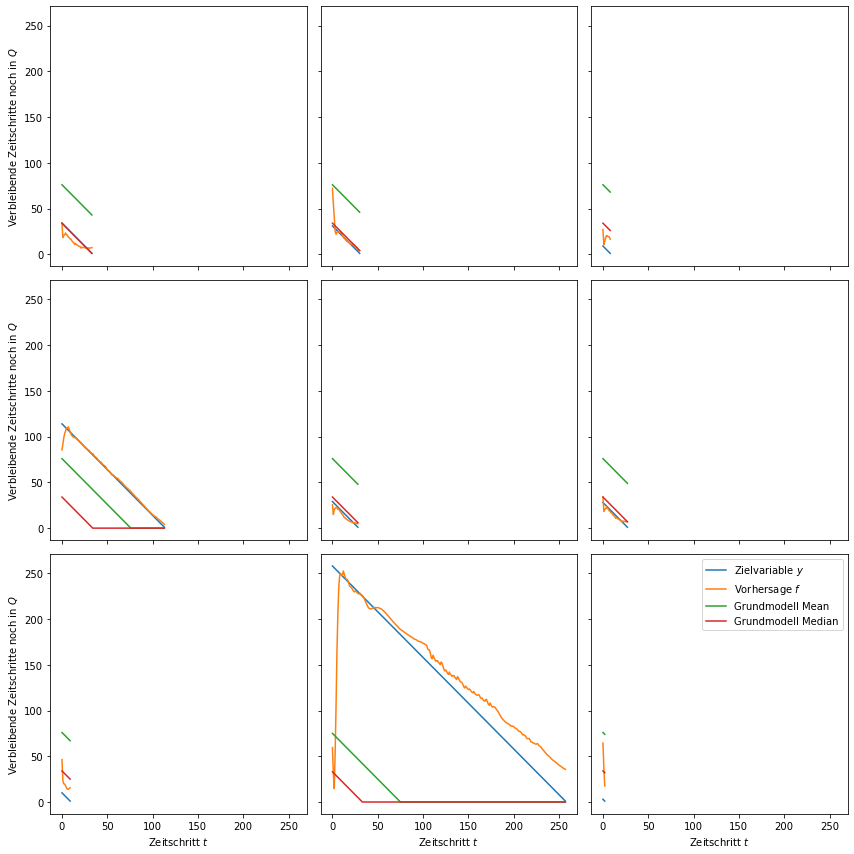

In [33]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_20epochs_25neurons.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

#### 50 Neurons

In [34]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_20epochs_50neurons.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=20, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_20epochs_50neurons.h5')

Epoch 1/20
203/203 [==============================] - 137s 676ms/step - loss: 0.0599 - mae: 0.5450 - val_loss: 0.0492 - val_mae: 0.4692
Epoch 2/20
203/203 [==============================] - 128s 632ms/step - loss: 0.0499 - mae: 0.4535 - val_loss: 0.0455 - val_mae: 0.4334
Epoch 3/20
203/203 [==============================] - 128s 629ms/step - loss: 0.0489 - mae: 0.4446 - val_loss: 0.0448 - val_mae: 0.4271
Epoch 4/20
203/203 [==============================] - 126s 623ms/step - loss: 0.0477 - mae: 0.4339 - val_loss: 0.0446 - val_mae: 0.4250
Epoch 5/20
203/203 [==============================] - 126s 622ms/step - loss: 0.0467 - mae: 0.4249 - val_loss: 0.0427 - val_mae: 0.4070
Epoch 6/20
203/203 [==============================] - 126s 622ms/step - loss: 0.0464 - mae: 0.4220 - val_loss: 0.0418 - val_mae: 0.3980
Epoch 7/20
203/203 [==============================] - 126s 622ms/step - loss: 0.0459 - mae: 0.4176 - val_loss: 0.0418 - val_mae: 0.3985
Epoch 8/20
203/203 [============================

MAE        :  35.2
MAE Mean   :  82.27
MAE Median :  87.23


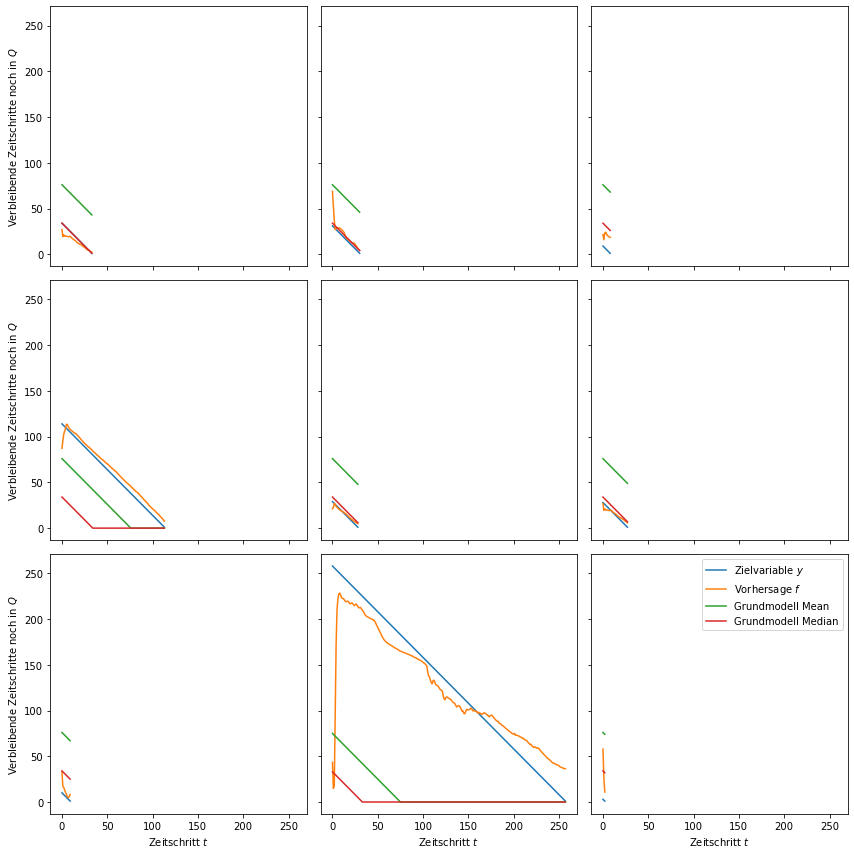

In [35]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_20epochs_50neurons.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

### Outlier Tests

#### Min 10 Max 300

In [36]:
X, y, maxlen = create_dataset_train(q_one, q_two, outlier_min=10, outlier_max=300)

INFO:root:2806 items in the first and second queue
INFO:root:9039 items in the second queue only
INFO:root:11845 items in the whole dataset
INFO:root:Create dataset: 19.14 time elapsed


#### Scaling

In [37]:
X_scaled, y_scaled = scale(X, y, start_date="2020-11-03",end_date="2020-11-07", 
                           epochs='50', steps='720', s_rate='20', model_name='test')

INFO:root:Scale: 55.13 time elapsed


#### Padding

In [38]:
X_train, X_test, y_train, y_test = pad_split(X_scaled, y_scaled, maxlen, test_size=0.3)

INFO:root:Pad Split: 0.26 time elapsed


In [39]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = downsample(X_train, X_test, y_train, y_test, rate=0.8)

INFO:root:Downsample: 0.05 time elapsed


In [40]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_20epochs_20neurons_outlier_10_300.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=20, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_20epochs_20neurons_outlier_10_300.h5')

Epoch 1/20
167/167 [==============================] - 101s 606ms/step - loss: 0.0633 - mae: 0.5734 - val_loss: 0.0558 - val_mae: 0.5038
Epoch 2/20
167/167 [==============================] - 99s 592ms/step - loss: 0.0503 - mae: 0.4556 - val_loss: 0.0474 - val_mae: 0.4281
Epoch 3/20
167/167 [==============================] - 97s 583ms/step - loss: 0.0444 - mae: 0.4020 - val_loss: 0.0435 - val_mae: 0.3929
Epoch 4/20
167/167 [==============================] - 97s 583ms/step - loss: 0.0423 - mae: 0.3831 - val_loss: 0.0418 - val_mae: 0.3774
Epoch 5/20
167/167 [==============================] - 97s 583ms/step - loss: 0.0411 - mae: 0.3722 - val_loss: 0.0411 - val_mae: 0.3709
Epoch 6/20
167/167 [==============================] - 97s 583ms/step - loss: 0.0406 - mae: 0.3676 - val_loss: 0.0404 - val_mae: 0.3647
Epoch 7/20
167/167 [==============================] - 97s 582ms/step - loss: 0.0401 - mae: 0.3627 - val_loss: 0.0401 - val_mae: 0.3625
Epoch 8/20
167/167 [==============================] - 

MAE        :  29.93
MAE Mean   :  79.84
MAE Median :  84.5


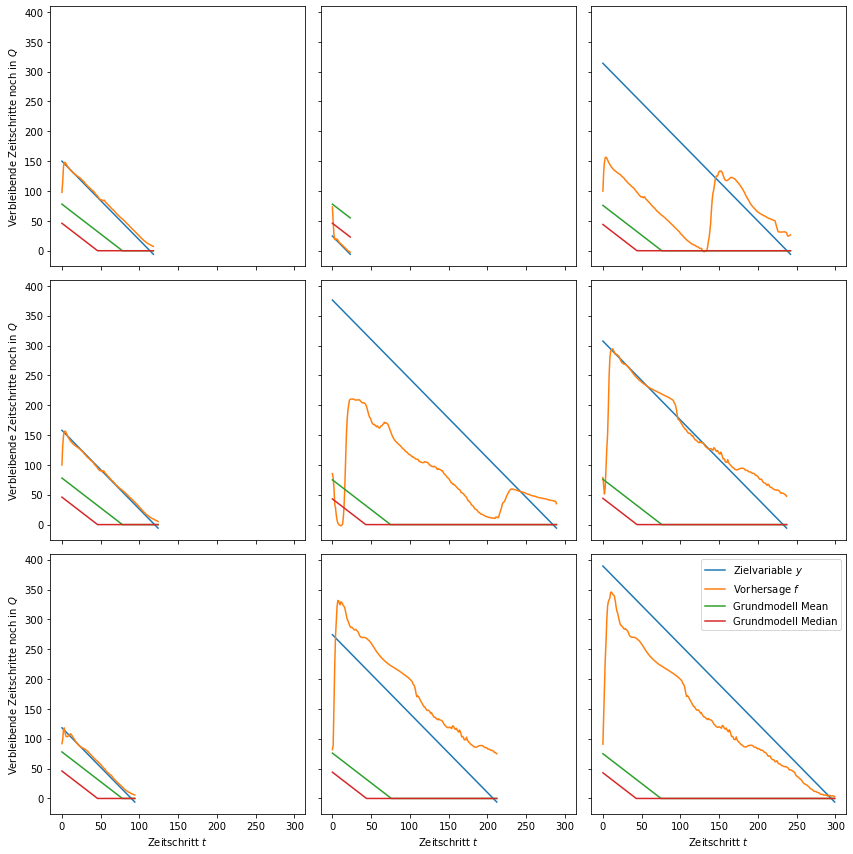

In [41]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_20epochs_20neurons_outlier_10_300.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

#### Min 25 Max 300

In [42]:
X, y, maxlen = create_dataset_train(q_one, q_two, outlier_min=25, outlier_max=300)

INFO:root:1955 items in the first and second queue
INFO:root:6884 items in the second queue only
INFO:root:8839 items in the whole dataset
INFO:root:Create dataset: 19.76 time elapsed


#### Scaling

In [43]:
X_scaled, y_scaled = scale(X, y, start_date="2020-11-03",end_date="2020-11-07", 
                           epochs='50', steps='720', s_rate='20', model_name='test')

INFO:root:Scale: 41.14 time elapsed


#### Padding

In [44]:
X_train, X_test, y_train, y_test = pad_split(X_scaled, y_scaled, maxlen, test_size=0.3)

INFO:root:Pad Split: 0.16 time elapsed


In [45]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = downsample(X_train, X_test, y_train, y_test, rate=0.8)

INFO:root:Downsample: 0.05 time elapsed


In [46]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_20epochs_20neurons_outlier_25_300.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=20, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_20epochs_20neurons_outlier_25_300.h5')

Epoch 1/20
125/125 [==============================] - 75s 602ms/step - loss: 0.0784 - mae: 0.5691 - val_loss: 0.0679 - val_mae: 0.4804
Epoch 2/20
125/125 [==============================] - 73s 586ms/step - loss: 0.0621 - mae: 0.4510 - val_loss: 0.0583 - val_mae: 0.4123
Epoch 3/20
125/125 [==============================] - 73s 581ms/step - loss: 0.0566 - mae: 0.4108 - val_loss: 0.0549 - val_mae: 0.3882
Epoch 4/20
125/125 [==============================] - 72s 580ms/step - loss: 0.0537 - mae: 0.3900 - val_loss: 0.0536 - val_mae: 0.3789
Epoch 5/20
125/125 [==============================] - 72s 578ms/step - loss: 0.0525 - mae: 0.3812 - val_loss: 0.0520 - val_mae: 0.3679
Epoch 6/20
125/125 [==============================] - 72s 577ms/step - loss: 0.0517 - mae: 0.3753 - val_loss: 0.0520 - val_mae: 0.3679
Epoch 7/20
125/125 [==============================] - 72s 578ms/step - loss: 0.0508 - mae: 0.3689 - val_loss: 0.0502 - val_mae: 0.3547
Epoch 8/20
125/125 [==============================] - 7

MAE        :  30.46
MAE Mean   :  77.58
MAE Median :  80.55


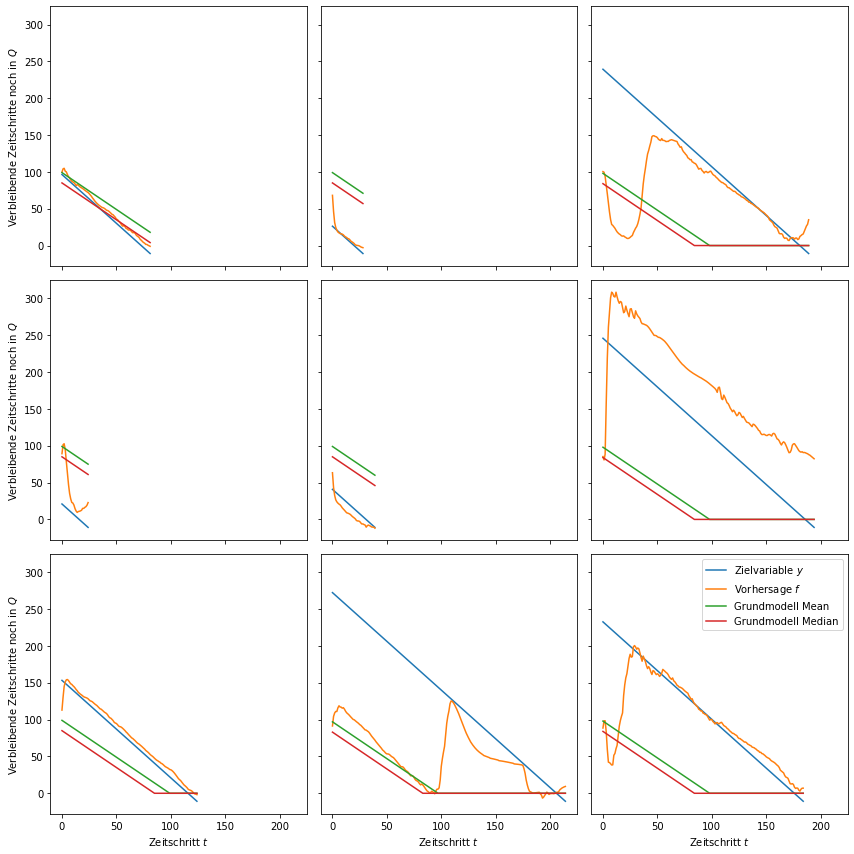

In [47]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_20epochs_20neurons_outlier_25_300.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

#### Min 10 Max 400

In [48]:
X, y, maxlen = create_dataset_train(q_one, q_two, outlier_min=10, outlier_max=400)

INFO:root:2834 items in the first and second queue
INFO:root:9253 items in the second queue only
INFO:root:12087 items in the whole dataset
INFO:root:Create dataset: 19.69 time elapsed


#### Scaling

In [49]:
X_scaled, y_scaled = scale(X, y, start_date="2020-11-03",end_date="2020-11-07", 
                           epochs='50', steps='720', s_rate='20', model_name='test')

INFO:root:Scale: 55.82 time elapsed


#### Padding

In [50]:
X_train, X_test, y_train, y_test = pad_split(X_scaled, y_scaled, maxlen, test_size=0.3)

INFO:root:Pad Split: 0.26 time elapsed


In [51]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = downsample(X_train, X_test, y_train, y_test, rate=0.8)

INFO:root:Downsample: 0.06 time elapsed


In [52]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_20epochs_20neurons_outlier_10_400.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=20, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_20epochs_20neurons_outlier_10_400.h5')

Epoch 1/20
171/171 [==============================] - 99s 577ms/step - loss: 0.0699 - mae: 0.5928 - val_loss: 0.0554 - val_mae: 0.4926
Epoch 2/20
171/171 [==============================] - 96s 561ms/step - loss: 0.0553 - mae: 0.4684 - val_loss: 0.0501 - val_mae: 0.4458
Epoch 3/20
171/171 [==============================] - 96s 562ms/step - loss: 0.0504 - mae: 0.4271 - val_loss: 0.0459 - val_mae: 0.4078
Epoch 4/20
171/171 [==============================] - 96s 560ms/step - loss: 0.0491 - mae: 0.4157 - val_loss: 0.0429 - val_mae: 0.3820
Epoch 5/20
171/171 [==============================] - 96s 562ms/step - loss: 0.0478 - mae: 0.4054 - val_loss: 0.0426 - val_mae: 0.3787
Epoch 6/20
171/171 [==============================] - 94s 552ms/step - loss: 0.0473 - mae: 0.4006 - val_loss: 0.0424 - val_mae: 0.3775
Epoch 7/20
171/171 [==============================] - 94s 552ms/step - loss: 0.0484 - mae: 0.4106 - val_loss: 0.0432 - val_mae: 0.3846
Epoch 8/20
171/171 [==============================] - 9

MAE        :  30.72
MAE Mean   :  81.5
MAE Median :  86.09


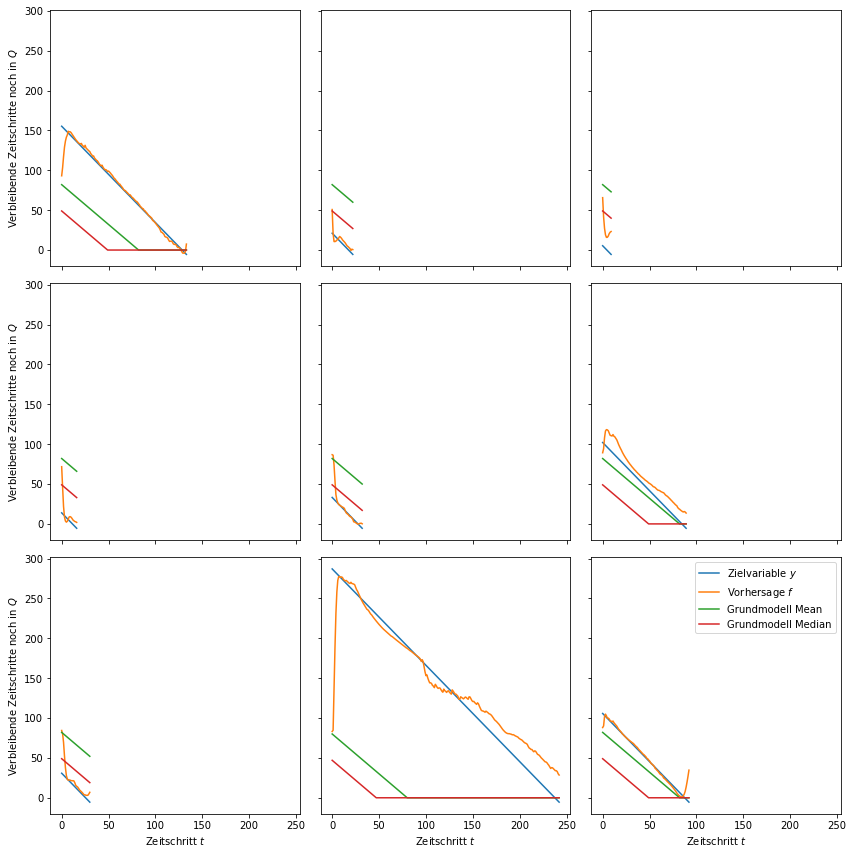

In [53]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_20epochs_20neurons_outlier_10_400.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)

#### Min 25 Max 400

#### Test 4

In [54]:
X, y, maxlen = create_dataset_train(q_one, q_two, outlier_min=25, outlier_max=400)

INFO:root:1983 items in the first and second queue
INFO:root:7098 items in the second queue only
INFO:root:9081 items in the whole dataset
INFO:root:Create dataset: 20.19 time elapsed


#### Scaling

In [55]:
X_scaled, y_scaled = scale(X, y, start_date="2020-11-03",end_date="2020-11-07", 
                           epochs='50', steps='720', s_rate='20', model_name='test')

INFO:root:Scale: 42.16 time elapsed


#### Padding

In [56]:
X_train, X_test, y_train, y_test = pad_split(X_scaled, y_scaled, maxlen, test_size=0.3)

INFO:root:Pad Split: 0.17 time elapsed


In [57]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = downsample(X_train, X_test, y_train, y_test, rate=0.8)

INFO:root:Downsample: 0.05 time elapsed


In [58]:
# Build the model
n_steps = X_train_sampled.shape[1]  # number of steps
n_features = X_train_sampled.shape[2]  # number of features

# Create model layer
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps, n_features)))  # Masking Layer for padding
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(1, input_dim=20))  # Dense Layer to generate 1Dimensional Outputs
model.compile(loss='mae', optimizer='adam', metrics=['mae'])

# Define CallBacks
early_stop = EarlyStopping(monitor='mae', mode='min', patience=10)
mcp_save = ModelCheckpoint(f'models/mcp_lstm_20epochs_20neurons_outlier_25_400.h5', 
                            save_best_only=True, monitor='mae', mode='min')

# Start training
model.fit(X_train_sampled, y_train_sampled, epochs=20, validation_split=0.2,
          callbacks=[early_stop, mcp_save])

# Save the model in models directory
model.save(f'models/lstm_20epochs_20neurons_outlier_25_400.h5')

Epoch 1/20
127/127 [==============================] - 76s 598ms/step - loss: 0.0848 - mae: 0.5659 - val_loss: 0.0737 - val_mae: 0.5083
Epoch 2/20
127/127 [==============================] - 72s 570ms/step - loss: 0.0710 - mae: 0.4736 - val_loss: 0.0676 - val_mae: 0.4661
Epoch 3/20
127/127 [==============================] - 68s 538ms/step - loss: 0.0662 - mae: 0.4413 - val_loss: 0.0623 - val_mae: 0.4297
Epoch 4/20
127/127 [==============================] - 68s 537ms/step - loss: 0.0634 - mae: 0.4232 - val_loss: 0.0659 - val_mae: 0.4546
Epoch 5/20
127/127 [==============================] - 64s 507ms/step - loss: 0.0619 - mae: 0.4131 - val_loss: 0.0625 - val_mae: 0.4309
Epoch 6/20
127/127 [==============================] - 64s 506ms/step - loss: 0.0612 - mae: 0.4084 - val_loss: 0.0595 - val_mae: 0.4102
Epoch 7/20
127/127 [==============================] - 64s 507ms/step - loss: 0.0603 - mae: 0.4020 - val_loss: 0.0601 - val_mae: 0.4145
Epoch 8/20
127/127 [==============================] - 6

MAE        :  31.31
MAE Mean   :  76.51
MAE Median :  79.23


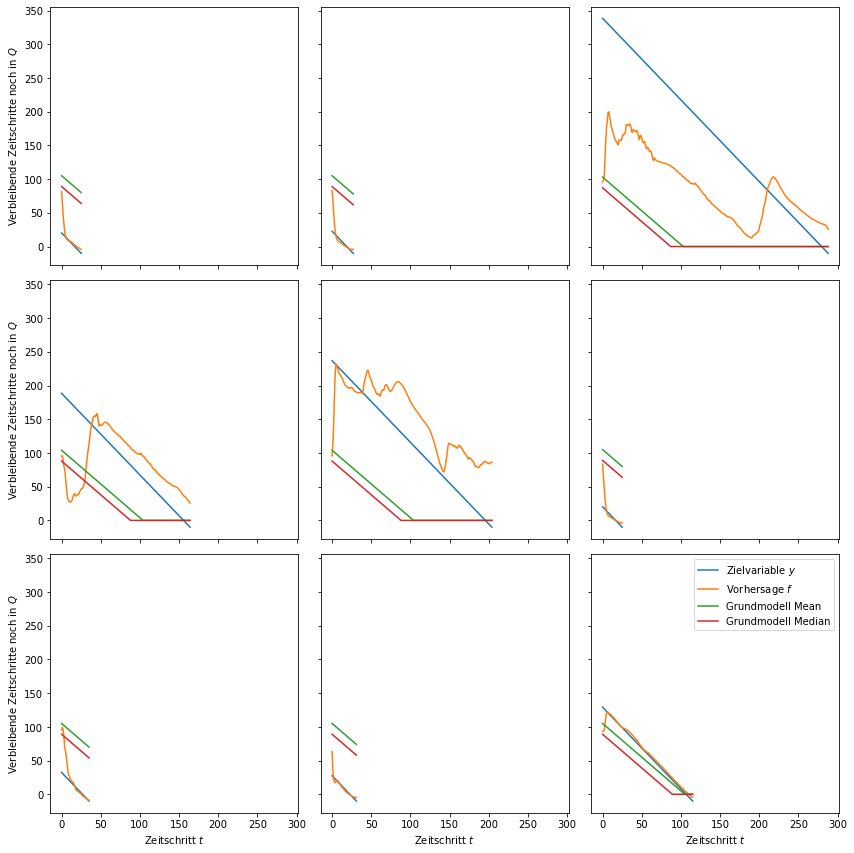

In [59]:
pred_mae(X_test_sampled, y_test_sampled, y, model='models/mcp_lstm_20epochs_20neurons_outlier_25_400.h5', 
         scaler_y='models/scalery_test_2020-06-09_2020-06-13_50epochs_720steps_20srate.p', n_plots=3, seed=3, model_name='LSTM',
         save_fig=False)